In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing

## Import data set of 20 newsgroups

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
groups=fetch_20newsgroups(subset='all',categories=['rec.sport.baseball','talk.politics.guns','comp.graphics','sci.med'])


In [4]:
labels = groups.target

In [5]:
label_names = groups.target_names

## Import NLTK

In [6]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

In [7]:
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

## clean data: lower, retain only alphabet, remove names, lemmatize

In [8]:
data_cleaned=[]
for doc in groups.data:
    doc=doc.lower()
    doc_cleaned=' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word.isalpha() and word not in all_names)
    data_cleaned.append(doc_cleaned)

## TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
tfidf_vector=TfidfVectorizer(stop_words='english',max_features=None,max_df=.5,min_df=2)
data=tfidf_vector.fit_transform(data_cleaned)

# Check what each clusters contains

In [ ]:
from sklearn.neighbors import NearestCentroid
from collections import Counter

In [ ]:
def print_each_clusters(model):
    clusters=model.labels_
    if 'n_clusters' in model.get_params():
        k=model.get_params()['n_clusters']
    else:
        #DBSCAN
        k=np.unique(model.labels_).shape[0]
    cluster_label={i:labels[np.where(clusters==i)] for i in range(k)}
    terms=np.array(tfidf_vector.get_feature_names_out())
    if hasattr(model, 'cluster_centers'):
        centroids=model.cluster_centers_
    else:
        #Agglomerative
        clf=NearestCentroid()
        clf.fit(data,clusters)
        centroids=clf.centroids_
    for cluster,index_list in cluster_label.items():
        counter=Counter(cluster_label[cluster])
        print('cluster_{}: {} samples'.format(cluster,len(index_list)))
        
        print('Top Keywords: {}'.format('/'.join(terms[centroids[cluster].argsort()[-10:][::-1]])))
        for label_index, count in sorted(counter.items(), key=lambda x: x[1],reverse=True):
            print('\t{}: {} samples'.format(label_names[label_index],count))


# Clustering

## Kmeans

In [140]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [141]:
k_list=np.arange(2,11)
kmeans={k:KMeans(n_clusters=k,n_init=20,random_state=0) for k in k_list}

In [142]:
for k,model in kmeans.items():
    print('\r{}'.format(k),end='',flush=True)
    model.fit(data)

10

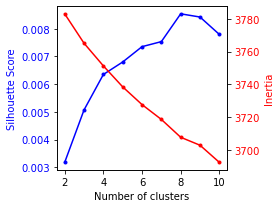

In [164]:
fig,ax=plt.subplots(tight_layout=True,figsize=(4,3))
ax.plot(k_list,[silhouette_score(data,km.labels_) for km in kmeans.values()],'.-',color='b')
ax.set_ylabel('Silhouette Score',color='b')
ax.tick_params(axis='y',labelcolor='b')


ax1=ax.twinx()
ax1.plot(k_list,[km.inertia_ for km in kmeans.values()],'.-',color='r')
ax.set_xlabel('Number of clusters') 
ax1.set_ylabel('Inertia',color='r')
ax1.tick_params(axis='y',labelcolor='r')



In [144]:
print_each_clusters(kmeans[4])

cluster_0: 698 samples
Top Keywords: gun/wa/people/fbi/government/article/atf/right/law/batf
	talk.politics.guns: 697 samples
	sci.med: 1 samples
cluster_1: 751 samples
Top Keywords: game/team/wa/player/baseball/article/hit/win/pitcher/brave
	rec.sport.baseball: 750 samples
	talk.politics.guns: 1 samples
cluster_2: 670 samples
Top Keywords: graphic/image/file/program/format/need/university/looking/know/bit
	comp.graphics: 660 samples
	sci.med: 8 samples
	rec.sport.baseball: 2 samples
cluster_3: 1748 samples
Top Keywords: wa/article/university/ha/know/like/just/doe/medical/computer
	sci.med: 981 samples
	comp.graphics: 313 samples
	rec.sport.baseball: 242 samples
	talk.politics.guns: 212 samples


In [145]:
print_each_clusters(kmeans[8])

cluster_0: 382 samples
Top Keywords: wa/fbi/atf/batf/government/waco/burn/dividian/article/people
	talk.politics.guns: 381 samples
	sci.med: 1 samples
cluster_1: 706 samples
Top Keywords: game/team/wa/player/baseball/hit/article/pitcher/brave/win
	rec.sport.baseball: 705 samples
	sci.med: 1 samples
cluster_2: 1435 samples
Top Keywords: university/wa/article/know/doe/just/ha/like/thanks/computer
	comp.graphics: 537 samples
	sci.med: 402 samples
	rec.sport.baseball: 289 samples
	talk.politics.guns: 207 samples
cluster_3: 317 samples
Top Keywords: gun/people/firearm/right/law/weapon/wa/like/article/criminal
	talk.politics.guns: 317 samples
cluster_4: 439 samples
Top Keywords: image/graphic/file/program/format/bit/color/need/computer/display
	comp.graphics: 435 samples
	sci.med: 4 samples
cluster_5: 58 samples
Top Keywords: msg/food/sensitivity/chinese/restaurant/reaction/eat/allergic/people/effect
	sci.med: 58 samples
cluster_6: 455 samples
Top Keywords: doctor/ha/wa/medical/patient/disea

## Agglomerative Clustering

In [15]:
from sklearn.cluster import AgglomerativeClustering


In [50]:
k_list=np.arange(2,10)
agg_cluster={k:AgglomerativeClustering(n_clusters=k,compute_full_tree=True,memory='cache') for k in k_list}

In [51]:
for k, model in agg_cluster.items():
    print('\r{}'.format(k),end='',flush=True)
    model.fit(data.toarray())

3

/home/jake/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1001: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  out = memory.cache(tree_builder)(


9

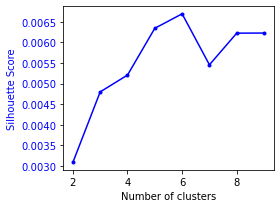

In [52]:
fig,ax=plt.subplots(tight_layout=True,figsize=(4,3))
ax.plot(k_list,[silhouette_score(data,model.labels_)  for model in agg_cluster.values()],'.-',color='b')
ax.set_xlabel('Number of clusters') 
ax.set_ylabel('Silhouette Score',color='b')

ax.tick_params(axis='y',labelcolor='b')

In [163]:
print_each_clusters(agg_cluster[5])

cluster_0: 839 samples
Top Keywords: game/wa/team/player/baseball/article/hit/ha/win/think
	rec.sport.baseball: 815 samples
	sci.med: 13 samples
	comp.graphics: 6 samples
	talk.politics.guns: 5 samples
cluster_1: 791 samples
Top Keywords: gun/wa/people/fbi/article/government/right/atf/like/law
	talk.politics.guns: 772 samples
	comp.graphics: 9 samples
	sci.med: 6 samples
	rec.sport.baseball: 4 samples
cluster_2: 1416 samples
Top Keywords: wa/article/university/ha/know/medical/science/like/doe/computer
	sci.med: 896 samples
	comp.graphics: 227 samples
	rec.sport.baseball: 166 samples
	talk.politics.guns: 127 samples
cluster_3: 58 samples
Top Keywords: msg/food/sensitivity/chinese/restaurant/allergic/eat/reaction/people/flavor
	sci.med: 58 samples
cluster_4: 763 samples
Top Keywords: graphic/image/file/program/university/need/format/computer/know/bit
	comp.graphics: 731 samples
	sci.med: 17 samples
	rec.sport.baseball: 9 samples
	talk.politics.guns: 6 samples


In [57]:
print_each_clusters(agg_cluster[6])

cluster_0: 791 samples
Top Keywords: gun/wa/people/fbi/article/government/right/atf/like/law
	talk.politics.guns: 772 samples
	comp.graphics: 9 samples
	sci.med: 6 samples
	rec.sport.baseball: 4 samples
cluster_1: 763 samples
Top Keywords: graphic/image/file/program/university/need/format/computer/know/bit
	comp.graphics: 731 samples
	sci.med: 17 samples
	rec.sport.baseball: 9 samples
	talk.politics.guns: 6 samples
cluster_2: 1416 samples
Top Keywords: wa/article/university/ha/know/medical/science/like/doe/computer
	sci.med: 896 samples
	comp.graphics: 227 samples
	rec.sport.baseball: 166 samples
	talk.politics.guns: 127 samples
cluster_3: 58 samples
Top Keywords: msg/food/sensitivity/chinese/restaurant/allergic/eat/reaction/people/flavor
	sci.med: 58 samples
cluster_4: 803 samples
Top Keywords: game/team/wa/player/article/hit/baseball/ha/win/brave
	rec.sport.baseball: 779 samples
	sci.med: 13 samples
	comp.graphics: 6 samples
	talk.politics.guns: 5 samples
cluster_5: 36 samples
Top Ke

## DBSCAN

In [65]:
from sklearn.model_selection import GridSearchCV

In [127]:
eps_list=np.arange(.5,1.5,.1)
min_samples_list=np.arange(2,15)

In [112]:
def scoring_silhouette(estimator,X):
    estimator.fit(X)
    cluster_labels=estimator.labels_
    if np.unique(cluster_labels).shape[0]>=2:
        return silhouette_score(data,cluster_labels)
    else:
        return 0

In [113]:
search=GridSearchCV(DBSCAN(),{'eps':eps_list,'min_samples':min_samples_list},n_jobs=-1,verbose=3,cv=[(slice(None),slice(None))],scoring=scoring_silhouette)

In [114]:
search.fit(data)

Fitting 1 folds for each of 130 candidates, totalling 130 fits
[CV 1/1] END ............eps=0.5, min_samples=9;, score=0.000 total time=   2.7s
[CV 1/1] END ............eps=0.5, min_samples=8;, score=0.000 total time=   3.6s
[CV 1/1] END ............eps=0.5, min_samples=7;, score=0.003 total time=   4.0s
[CV 1/1] END ...........eps=0.5, min_samples=3;, score=-0.020 total time=   4.4s
[CV 1/1] END ............eps=0.5, min_samples=4;, score=0.003 total time=   4.6s
[CV 1/1] END ...........eps=0.5, min_samples=2;, score=-0.033 total time=   4.6s
[CV 1/1] END ............eps=0.5, min_samples=6;, score=0.003 total time=   4.9s
[CV 1/1] END ............eps=0.5, min_samples=5;, score=0.003 total time=   6.4s
[CV 1/1] END ...........eps=0.5, min_samples=10;, score=0.000 total time=   4.1s
[CV 1/1] END ...........eps=0.5, min_samples=13;, score=0.000 total time=   3.2s
[CV 1/1] END ...........eps=0.5, min_samples=11;, score=0.000 total time=   3.8s
[CV 1/1] END ...........eps=0.5, min_samples=1

GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=DBSCAN(), n_jobs=-1,
             param_grid={'eps': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
                         'min_samples': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring=<function scoring_silhouette at 0x7f635232f430>,
             verbose=3)

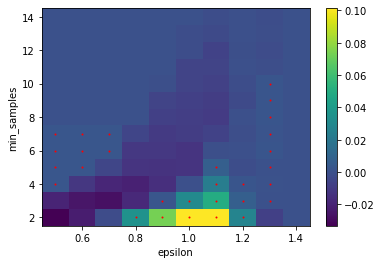

In [128]:
plt.pcolormesh(eps_list,min_samples_list,search.cv_results_['mean_test_score'].reshape((eps_list.shape[0],min_samples_list.shape[0])).T,shading='auto')
plt.colorbar()
plt.xlabel('epsilon')
plt.ylabel('min_samples')

plt.scatter(eps_candidate,min_samples_candidate,1,'r')

In [125]:
eps_candidate=[]
min_samples_candidate=[]
for params in np.array(search.cv_results_['params'])[search.cv_results_['mean_test_score']>0]:
    eps_candidate.append(params['eps'])
    min_samples_candidate.append(params['min_samples'])


In [129]:
dbscan=[DBSCAN(eps=eps,min_samples=min_samples) for eps, min_samples in zip(eps_candidate,min_samples_candidate)]

In [130]:
for idx, model in enumerate(dbscan):
    print('\r{}'.format(idx),end='',flush=True)
    model.fit(data)

28

In [172]:
ss=[silhouette_score(data,model.labels_) for model in dbscan]

In [180]:
print(' '.join(('{:.4f}'.format(ss)) for ss in ss))

0.0028 0.0028 0.0028 0.0028 0.0028 0.0028 0.0028 0.0028 0.0028 0.0346 0.0731 0.0028 0.1008 0.0307 0.1013 0.0498 0.0235 0.0070 0.0274 0.0071 0.0023 0.0004 0.0007 0.0003 0.0020 0.0020 0.0020 0.0020 0.0020


In [133]:
num_cluster=[np.unique(model.labels_).shape[0] for model in dbscan]

In [166]:
print(num_cluster)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 423, 564, 175, 651, 273, 619, 314, 181, 102, 334, 150, 104, 6, 5, 4, 2, 2, 2, 2, 2]


In [135]:
[num_cluster.index(i) for i in [4,5,6]]

[23, 22, 21]

In [136]:
print_each_clusters(dbscan[21])

cluster_0: 3754 samples
Top Keywords: wa/ha/world/like/university/heard/research/article/similar/japanese
	rec.sport.baseball: 984 samples
	comp.graphics: 953 samples
	sci.med: 930 samples
	talk.politics.guns: 887 samples
cluster_1: 4 samples
Top Keywords: wa/article/university/ha/like/know/just/think/people/gun
	sci.med: 4 samples
cluster_2: 5 samples
Top Keywords: leung/drink/ng/ho/lactose/intolerance/experiencing/milk/ton/hardly
	sci.med: 5 samples
cluster_3: 3 samples
Top Keywords: centipede/millipede/posionous/pes/bitten/liable/clarification/know/concerted/soon
	comp.graphics: 3 samples
cluster_4: 3 samples
Top Keywords: playmation/retail/ren/hitchhiking/kenbaer/anjon/hash/sell/scn/marino
	sci.med: 3 samples
cluster_5: 0 samples
Top Keywords: acetaminophen/hepatic/mg/deadly/protein/toxicity/metabolism/hcl/succinate/dextromethorphan


In [137]:
print_each_clusters(dbscan[22])

cluster_0: 3725 samples
Top Keywords: wa/ha/world/like/university/article/research/playmation/know/information
	rec.sport.baseball: 979 samples
	comp.graphics: 948 samples
	sci.med: 918 samples
	talk.politics.guns: 880 samples
cluster_1: 4 samples
Top Keywords: wa/article/university/ha/like/know/just/think/people/gun
	sci.med: 4 samples
cluster_2: 4 samples
Top Keywords: leung/drink/ng/ho/lactose/intolerance/experiencing/milk/ton/hardly
	sci.med: 4 samples
cluster_3: 5 samples
Top Keywords: acne/oily/face/teenage/skin/wash/son/clearasil/dalacin/nose
	sci.med: 5 samples
cluster_4: 0 samples
Top Keywords: centipede/millipede/posionous/pes/bitten/liable/clarification/know/concerted/soon


In [138]:
print_each_clusters(dbscan[23])

cluster_0: 3698 samples
Top Keywords: wa/ha/university/article/world/like/information/think/know/leung
	rec.sport.baseball: 976 samples
	comp.graphics: 945 samples
	sci.med: 902 samples
	talk.politics.guns: 875 samples
cluster_1: 5 samples
Top Keywords: wa/article/university/ha/like/know/just/think/people/gun
	sci.med: 5 samples
cluster_2: 4 samples
Top Keywords: centipede/millipede/posionous/pes/bitten/liable/clarification/know/concerted/soon
	sci.med: 4 samples
cluster_3: 0 samples
Top Keywords: altitude/city/feel/travel/faint/dehydrating/caffeine/comfortable/ensure/lot


Therefore, DBSCAN does not apply here

# Evaluation 

In [146]:
from sklearn.metrics import adjusted_rand_score

In [148]:
adjusted_rand_score(labels,kmeans[4].labels_)

0.5006725028801597

In [161]:
{idx:adjusted_rand_score(labels,kmeans[idx].labels_) for idx in range(4,9)}

{4: 0.5006725028801597,
 5: 0.43271915320260496,
 6: 0.4333240778850958,
 7: 0.38252284408240195,
 8: 0.341547889469863}

In [162]:
{idx:adjusted_rand_score(labels,agg_cluster[idx].labels_) for idx in range(4,9)}

{4: 0.4544532866399254,
 5: 0.6015570850695279,
 6: 0.5899341335663643,
 7: 0.5552643421385994,
 8: 0.5453292912899739}

In [181]:
{idx:adjusted_rand_score(labels,dbscan[idx].labels_) for idx in range(21,24)}

{21: 0.00026352020971267995,
 22: 0.00038390580944541974,
 23: 0.0007234387860883634}